### Compare PPD predictions with GPy

From Rasmussen & Williams, the way that the mean of the PPD is calculated is through a linear combination of the values of the training function at each training point, where the coefficients for each training point are given by:

$$\bar{f_\star}=K(X_\star,X)K(X,X)^{-1}\mathbf{f}$$


In this notebook, we define these weights as $W(X_\star,X)\equiv K(X_\star,X)K(X,X)^{-1}$ and aim to plot them to give some visual representation of how a given emulator prediction is actually made from the training data. Whilst the above equation can be evaluated for a vector $f_\star$, essentially corresponding to making several emulator calls simulaneously at once, for simplicity in this case we evaluate it at just one point in parameter space. This means $K(X_\star,X)$ a row vector with each element being the covariance between the test point and each training point. Then the product of $K(X_\star,X)K(X,X)^{-1}=W(X_\star,X)$ is another row vector, where each entry represents the contribution to the linear combination of each training point, which is the quantity of interest in this notebook.

In particular I want to evaluate this equation myself to see if it gives the correct prediction, to ensure that the plots I have been making are correct and that this is in fact what the GP is doing. I will start off by looking at just the combined kernel.

Note Andreu added a new notebook called training_point_contributios that is based on this one.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
import gp_emulator
import p1d_arxiv
import test_simulation
import matplotlib
import copy

font = {'size'   : 14}

matplotlib.rc('font', **font)
plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=None
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0

In [3]:
# Set up emulator training set
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,
                                kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [5]:
## Set up test simulation object
test_sim=test_simulation.TestSimulation(sim_label="central",
            basedir=basedir,skewers_label=skewers_label,z_max=4,kmax_Mpc=kmax_Mpc,kp_Mpc=arxiv.kp_Mpc)
emu_call_dict=test_sim.get_emulator_calls(2.75)
emu_call=emu.return_unit_call(emu_call_dict)

In [6]:
## Add this parameter vector to the X training data
emu_call=np.expand_dims(emu_call,axis=0) ## Expand number of dimensions to match X grid

## The following is essentially a list of parameter vectors
## The first entry is the test point defined above
## The remining entries are the position vectors for each training point
## Have to do it this way as GPy doesn't allow individual calculations of the
## covariances apparently
test_and_training=np.concatenate((emu_call,emu.X_param_grid),axis=0)

In [7]:
## Now calculate the covariance
## Linear only
C_lin=emu.gp.kern.linear.K(test_and_training)

## RBF only
C_rbf=emu.gp.kern.rbf.K(test_and_training)

## Full kernel
C_full=emu.gp.kern.K(test_and_training)


## These matrices are actually:  K(X*,X*), K(X*,X)
##                               K(X,X*) , K(X,X)
## so we define K(X*,X) and K(X,X) below
K_star_full=C_full[0,1:]
K_full=C_full[1:,1:]

In [8]:
#K_inv_rbf=np.linalg.inv(C_rbf)
#K_inv_lin=np.linalg.inv(C_lin)
K_inv_full=np.linalg.inv(K_full) 

#W_rbf=C_rbf[0]*K_inv_rbf
#W_lin=C_lin[0]*K_inv_lin
W_full=np.matmul(K_star_full,K_inv_full)

<Figure size 2100x2100 with 0 Axes>

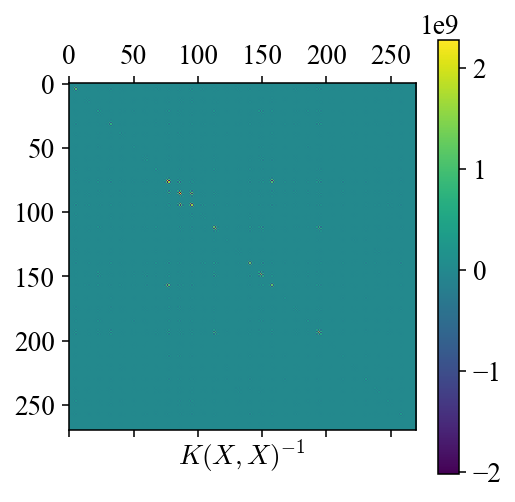

In [9]:
plt.figure(figsize=(15,15))
plt.matshow(K_inv_full)
plt.xlabel(r"$K(X,X)^{-1}$")
plt.colorbar()

In [10]:
## Select parameters along which to project
param1="mF"
param2="Delta2_p"

emu_data=arxiv.data
Nemu=len(emu_data)

emu_1=np.empty(Nemu)
emu_2=np.empty(Nemu)

ppd_weight_full=np.empty(Nemu)

for aa in range(Nemu):
    emu_1[aa]=emu_data[aa][param1]
    emu_2[aa]=emu_data[aa][param2]
    ppd_weight_full[aa]=W_full[aa]
    
## Point where the emu calls were made
call_1=emu_call_dict[param1]
call_2=emu_call_dict[param2]

In [11]:
## Select colourmap
cmap=cm.PiYG

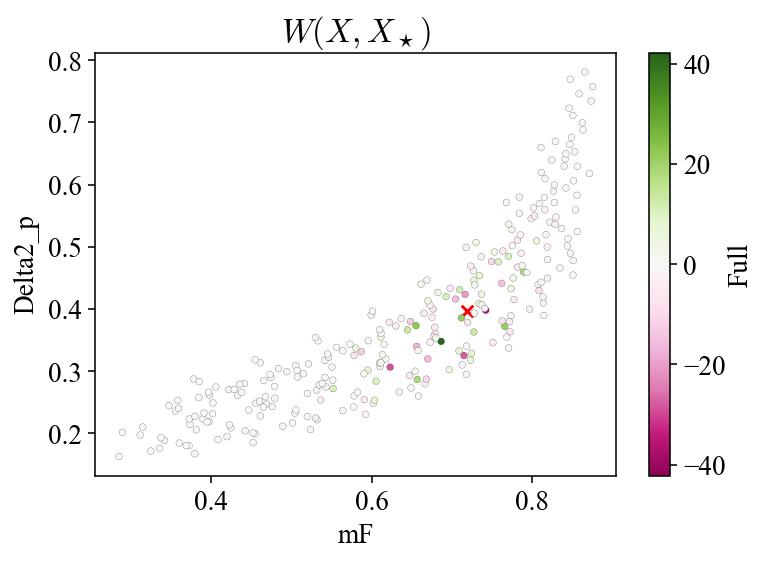

In [12]:
zmax=max(ppd_weight_full)
zmin=-1.*zmax

plt.title(r"$W(X,X_\star)$")
plt.scatter(call_1,call_2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=ppd_weight_full,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("Full", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

This looks bizarre, as the majority of the contributions to the prediction come from training points far away. I don't know that this is necessarily pathological though. There are several small teaks being made to the prediction by training points in the vicinity of the test point. It's possible that as the test point moves around, these contributions are finely tweaked to model the changes in the function. To test this, I will evaluate the equation at the top of this text myself using the weights shown in the plot, and see if what I get out agrees with the emulator prediction.

In [13]:
## All the training points in the lowest k bin
training_y=emu.Ypoints

In [14]:
my_pred=np.dot(W_full,training_y)
emu_pred,cov=emu.predict(emu_call_dict)

Text(0.5, 0, 'k bin')

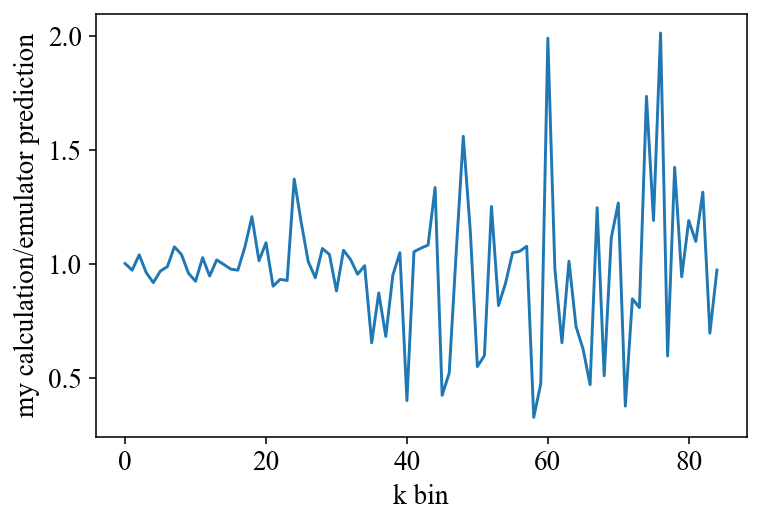

In [15]:
plt.plot(my_pred/emu_pred)
plt.ylabel("my calculation/emulator prediction")
plt.xlabel("k bin")

I think what I'm doing is correct but my predictions are noisy as the accuracy of my matrix inversions are poor, where the ones done within `GPy` are probably more accurate

In [16]:
def get_weights_from_call(emu_call_dic):
    """ For a given emulator call dictionary, return
    a W(X*,X) vector with the weight coefficients for
    each training point """
    emu_call=emu.return_unit_call(emu_call_dic)
    ## Add this parameter vector to the X training data
    emu_call=np.expand_dims(emu_call,axis=0) ## Expand number of dimensions to match X grid
    test_and_training=np.concatenate((emu_call,emu.X_param_grid),axis=0)

    ## Full kernel
    C_full=emu.gp.kern.K(test_and_training)
    K_star_full=C_full[0,1:]
    K_full=C_full[1:,1:]

    K_inv_rbf=np.linalg.inv(C_rbf)
    #K_inv_lin=np.linalg.inv(C_lin)
    K_inv_full=np.linalg.inv(K_full) 

    #W_rbf=C_rbf[0]*K_inv_rbf
    #W_lin=C_lin[0]*K_inv_lin
    W_full=np.matmul(K_star_full,K_inv_full)
    
    return W_full

## A small change to $<F>$

Let's see what happens to the weights of the training points if a change the emulator call by a small distance in $<F>$ for example.

In [17]:
emu_call_z2=test_sim.get_emulator_calls(3)
emu_call_mf=copy.deepcopy(emu_call_z2)
emu_call_mf["mF"]-=0.01

W_z2=get_weights_from_call(emu_call_z2)
W_mf=get_weights_from_call(emu_call_mf)

call_z2_par1=emu_call_z2[param1]
call_z2_par2=emu_call_z2[param2]
call_mf_par1=emu_call_mf[param1]
call_mf_par2=emu_call_mf[param2]

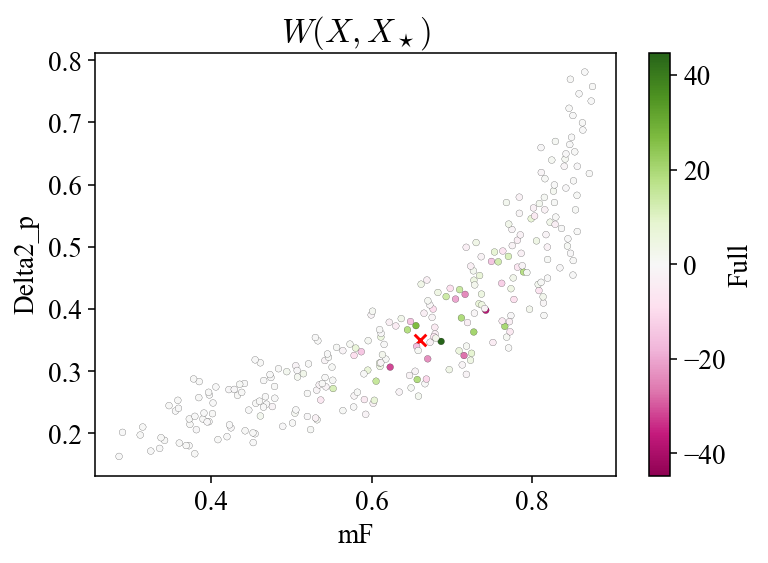

In [18]:
zmax=max(W_z2)
zmin=-1.*zmax

plt.title(r"$W(X,X_\star)$")
plt.scatter(call_z2_par1,call_z2_par2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=W_z2,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("Full", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

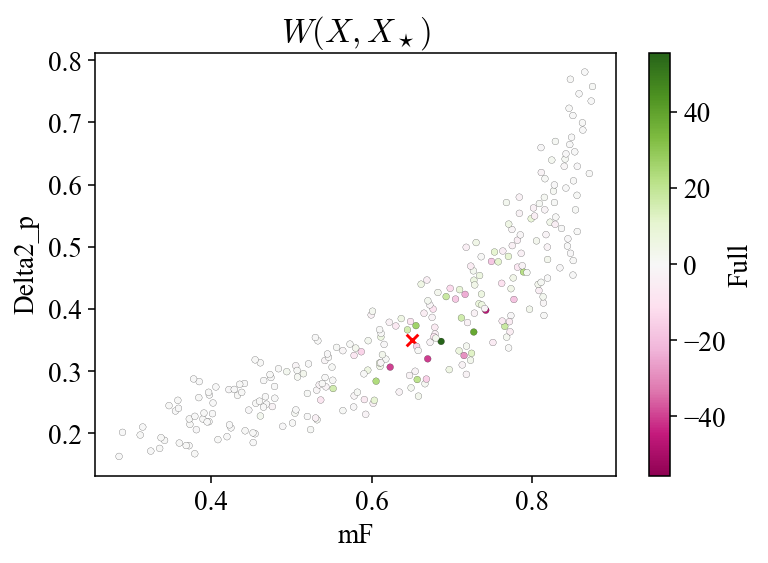

In [19]:
zmax=max(W_mf)
zmin=-1.*zmax

plt.title(r"$W(X,X_\star)$")
plt.scatter(call_mf_par1,call_mf_par2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=W_mf,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("Full", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

Now we plot the change in the weights as we change the mean flux

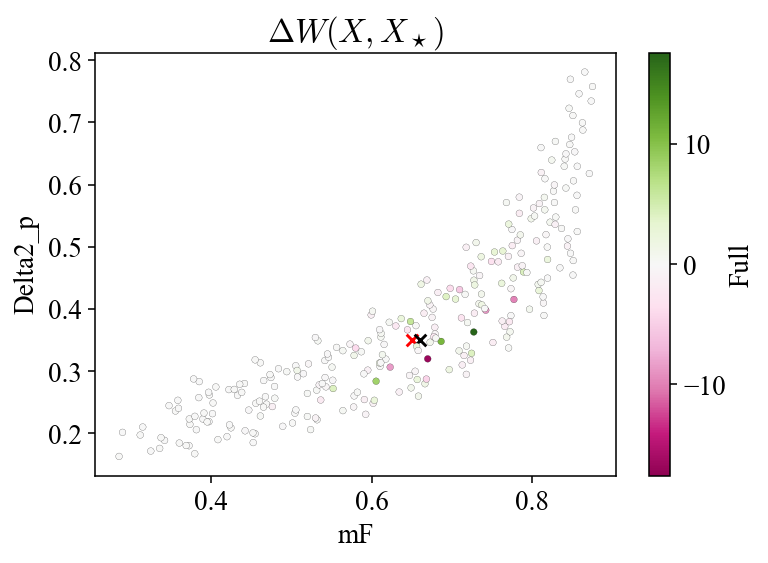

In [20]:
zmax=max(W_mf-W_z2)
zmin=-1.*zmax

plt.title(r"$\Delta W(X,X_\star)$")
plt.scatter(call_mf_par1,call_mf_par2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(call_z2_par1,call_z2_par2,c="black",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=W_mf-W_z2,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("Full", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

In [21]:
## Again lets plot my predictions with the GPy ones for these two more cases
my_pred_z2=np.dot(W_z2,training_y)
emu_pred_z2,cov=emu.predict(emu_call_z2)

my_pred_mf=np.dot(W_mf,training_y)
emu_pred_mf,cov=emu.predict(emu_call_mf)

Text(0.5, 0, 'k bin')

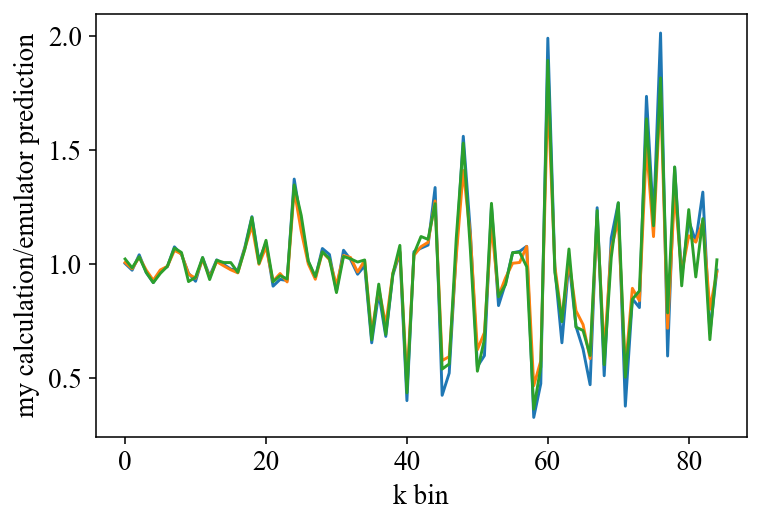

In [22]:
plt.plot(my_pred/emu_pred)
plt.plot(my_pred_z2/emu_pred_z2)
plt.plot(my_pred_mf/emu_pred_mf)
plt.ylabel("my calculation/emulator prediction")
plt.xlabel("k bin")

I think this is what the GP is doing, and the weights as I'm showing them are more or less correct, there are just some numerical inaccuracies that are degrading the quality of the predictions. Probably the plots are accurate enough to get some by-eye intution though. I think these spikes in the noise are common to all 3 lines as they come out of the matrix inversion of $K(X,X)$, which is kept constant.